In [2]:
import gym
import gym_futbol
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
import utils
from multiagent import MultiAgentModelProxy

pygame 2.1.0 (SDL 2.0.16, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Basics

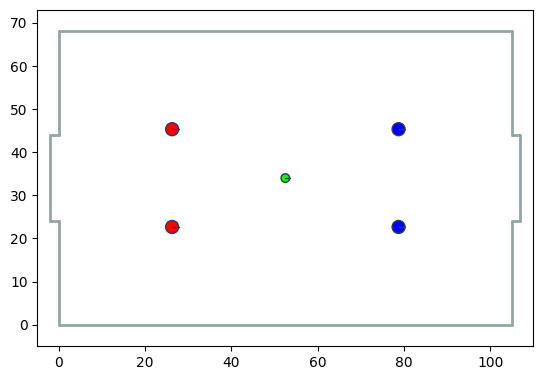

In [3]:
env = gym.make("Futbol2v2-v1")
env.render()

In [4]:
env.action_space

MultiDiscrete([5 5 5 5])

In [5]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

# Learning model

In [6]:
log_dir = "logs/"
timesteps = 10000

In [7]:
from stable_baselines3.common.env_util import make_vec_env

env = gym.make("Futbol2v2-v1")
env = make_vec_env(lambda: env, n_envs=4, monitor_dir=log_dir)
model = A2C("MlpPolicy", env, device='cpu')
model.learn(timesteps, progress_bar=True)
model.save("models/footbol2v2-a2c")

Output()

# Display model statistic

    index            r   l          t
0       0   206.421013  75   0.779745
1       1   351.053590  75   1.197700
2       2   106.588906  75   1.544925
3       3   192.607182  75   1.890073
4       4   -23.768020  75   2.250076
5       5   184.157859  75   2.595264
6       6   307.775208  75   2.946252
7       7   187.788800  75   3.303067
8       8   206.615175  75   3.650099
9       9   111.108424  75   3.994954
10     10    71.197876  75   4.344317
11     11  1339.741603  75   4.693666
12     12 -1130.919084  75   5.034440
13     13   144.802317  75   5.388956
14     14   261.863063  75   5.730578
15     15  1382.115670  75   6.097933
16     16    12.085449  75   6.444621
17     17   319.581637  75   6.796483
18     18   193.096158  75   7.156697
19     19  -306.652395  75   7.502851
20     20   175.546604  75   7.858694
21     21   228.013004  75   8.251568
22     22    85.427705  75   8.657824
23     23    83.664788  75   9.075188
24     24  -118.107827  75   9.705290
25     25   

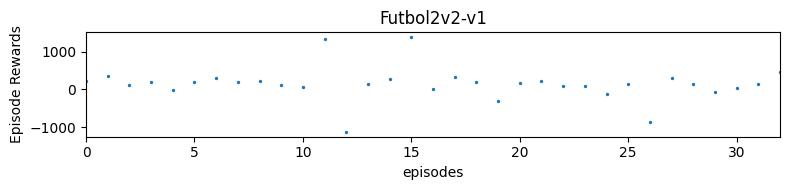

In [8]:
from IPython import display
from stable_baselines3.common import results_plotter

results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

log_data = results_plotter.load_results(log_dir)
print(log_data)

# Load model from file

In [9]:
model = A2C.load("models/footbol2v2-a2c", device="cpu")

# Run models

## Pygame
Run game with model in new windows with pygame

In [11]:
RES = WIDTH, HEIGHT = 600, 600
FPS = 60

env = gym.make("Futbol2v2-v1", width=WIDTH-2, height=HEIGHT-2, player_radius=15, ball_radius=5)
visualizer = utils.PygameVisualizer(env, FPS)
visualizer.run(model)

env.close()
visualizer.close()

## Matplotlib
Run model in notebook with matplotlib

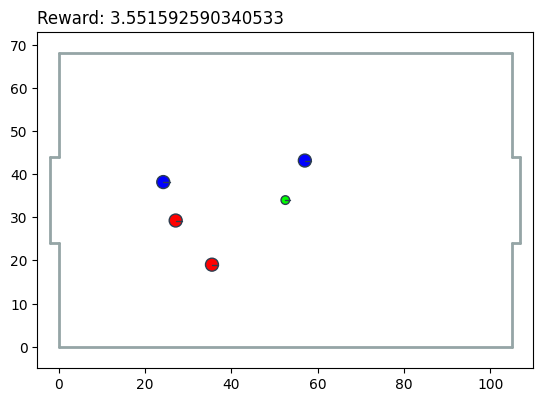

In [10]:
env = gym.make("Futbol2v2-v1")

visualizer = utils.MatplotlibVisualizer(env)
visualizer.run(model)

env.close()

# MultiAgent

## Learn

In [14]:
env = make_vec_env(lambda: gym.make("Futbol2v2-v1"), n_envs=1)

models = [
    MultiAgentModelProxy(A2C("MlpPolicy",
                             utils.TransformAction(env, lambda a: a[:2], gym.spaces.MultiDiscrete([5, 5])),
                             device='cpu')),
    MultiAgentModelProxy(A2C("MlpPolicy",
                             utils.TransformAction(env, lambda a: a[2:], gym.spaces.MultiDiscrete([5, 5])),
                             device='cpu'))
]

timesteps = 100
n_records_count = models[0].model.n_steps
max_episode_reward = 0

### Rewrote learning cycle
StableBaselines3 не поддерживает одновременное обучение нескольких агентов, это даже не ошибка по мнению разработчиков. Они считают, что в данном случае каждому пользователю необходимо самостоятельо переопределить цикл обучения (для не мультиагентных задач используется метод learn). Здесь представлен код, взятый из исходных кодов StableBaselines3, но адаптированный для многоагентных задач.
В обычной ситуации, learn сам взаимодействует со средой. Но при существовании нескольких агентов нужно получить действие от каждого и только потом передавать их в среду. Именно это здесь и реализовано. Каждому агенту передается наблюдение от среды (в данной задаче оно одинаково для всех) и получается действие. Затем действия объеядиняются и передаются среде. Затем каждый агент обновляется с учетом полученных данных (метод record).
Весь код, взятый из StableBaselines3 вынесен в класс MultiAgentModelProxy.

In [15]:
#TODO: рассмотреть возможность асинхронной среды
#TODO: добавить вывод логов для последующего использования results_plotter

In [16]:
for model in models:
    model.start_learning(timesteps)

for time in range(timesteps):
    done = False
    episode_reward = 0
    observation = env.reset()

    while not done:
        actions = [model.predict(observation)[0] for model in models]
        total_action = np.concatenate(np.concatenate(actions))

        for model in models:
            model.start_record()

        for step in range(n_records_count):
            next_observation, reward, done, info = env.step(np.array([total_action]))
            episode_reward += reward

            for model, action in zip(models, actions):
                model.record(observation, action, next_observation, reward, done, info)

        for model in models:
            model.end_record()
            model.train()

    if episode_reward > max_episode_reward:
        max_episode_reward = episode_reward
        for index, model in enumerate(models):
            model.model.save(f"models/footbol2v2-a2c-best-{index}")
    print(time, episode_reward)

for index, model in enumerate(models):
            model.model.save(f"models/footbol2v2-a2c-last-{index}")

0 [965.8441]
1 [748.2335]
2 [-715.14636]
3 [651.71564]
4 [712.65283]
5 [-603.6256]
6 [2038.2041]
7 [499.41772]
8 [-659.0229]
9 [-2226.021]
10 [-520.06506]
11 [2751.384]
12 [-1663.4227]
13 [504.84506]
14 [921.69586]
15 [746.57544]
16 [-1160.2308]
17 [525.8244]
18 [498.94705]
19 [-898.26746]
20 [1844.0658]
21 [705.76794]
22 [-1305.7924]
23 [928.4192]
24 [1956.7708]
25 [542.7213]
26 [670.9968]
27 [-902.91785]
28 [-197.95216]
29 [-1239.7382]
30 [483.7052]
31 [1119.8011]
32 [2095.1726]
33 [-1439.9849]
34 [-1135.327]
35 [-803.6637]
36 [-245.45587]
37 [3034.4846]
38 [974.4735]
39 [595.49176]
40 [900.18774]
41 [-1658.5305]
42 [1780.7661]
43 [735.14685]
44 [598.49036]
45 [-1071.2948]
46 [920.4387]
47 [723.6651]
48 [-761.20624]
49 [408.75894]
50 [-1309.1957]
51 [753.7005]
52 [2028.3087]
53 [-313.5378]
54 [-662.9027]
55 [-21.226877]
56 [1392.7621]
57 [967.7557]
58 [-1743.7847]
59 [479.55048]
60 [-1515.4174]
61 [668.54913]
62 [336.89603]
63 [272.03406]
64 [-116.206]
65 [225.59688]
66 [255.18071]
6

## Load and visualise

In [19]:
models = [A2C.load(f"models/footbol2v2-a2c-last-{index}", device="cpu") for index in range(2)]

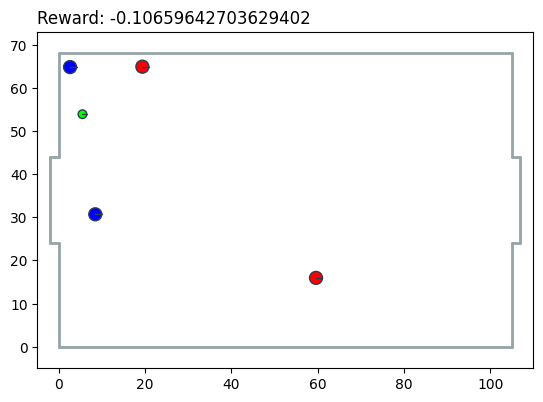

In [20]:
env = gym.make("Futbol2v2-v1")

multi_agent = utils.MultiModelAgent(models)

visualizer = utils.MatplotlibVisualizer(env)
visualizer.run(multi_agent)

env.close()